## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_vertical_wavelet_toy_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/segmentAnything/toy/wavelet/vertical/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4000,
 3: 16000,
 4: 64000,
 5: 256000,
 6: 1024000,
 7: 4096000,
 8: 16384000,
 9: 65536000,
 10: 262144000}

Running 12760 CDFs


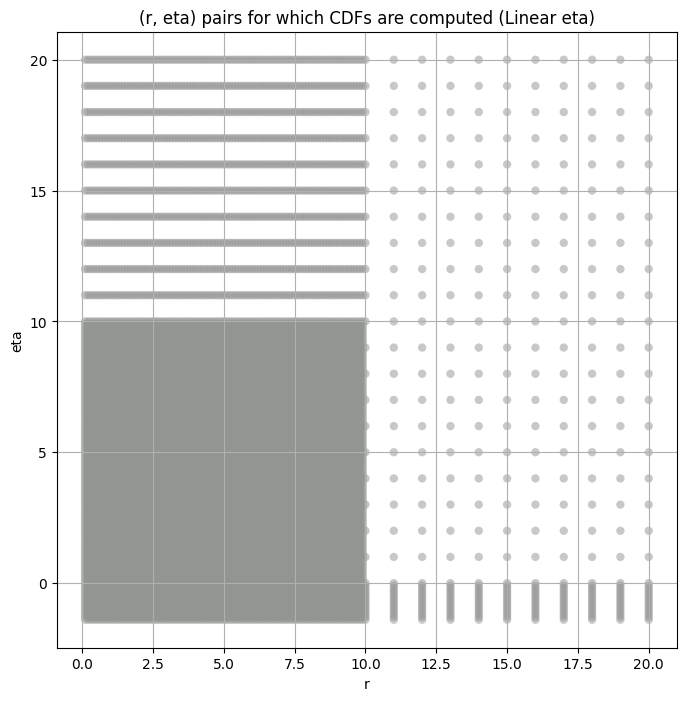

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      9030.142000  8175.746000  9933.516000   3.730290    2.927670   
3      2435.991200  2272.371600  2608.602800   5.225170    4.214867   
4       738.679750   680.785950   798.848700   7.656179    6.244269   
5       198.200070   181.349260   215.927780   9.336671    7.684987   
6        49.506360    45.094315    54.224213  10.842089    9.090936   
7        11.688205    10.574771    12.871078  12.554486   10.613249   
8         2.688385     2.419825     2.973556  13.938999   11.662300   
9         0.660523     0.592600     0.732903  15.165461   12.488104   
10        0.192761     0.173248     0.213634  14.628241   11.787691   

       kurt_upper  total_samples  
layer                             
2        4.566437           4000  
3        6.392464          16000  
4        9.261974          64000  
5       11.315386         256000  
6       12.832723        1024000  
7       14.772611        4096000  
8       16.595562       16384000  
9       18.324146       65536000  
10      17.827797      262144000

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      9030.142000    9030.141602     7243.062988     6259.179688   
3      2435.991200    2435.991211     2219.698975     2088.843750   
4       738.679750     738.679749      709.772339      689.791443   
5       198.200070     198.200073      192.268738      187.967453   
6        49.506360      49.506359       47.976208       46.824604   
7        11.688205      11.688205       11.305162       11.011557   
8         2.688385       2.688385        2.591965        2.519707   
9         0.660523       0.660523        0.634629        0.615414   
10        0.192761       0.192761        0.185032        0.179232   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         5570.368652      5043.493164      4239.862793      3640.546143   
3         1984.047241      1896.562988      1747.966675      1622.859497   
4          672.904297       658.040405       632.621399       610.996216   
5          184.329376       181.102753       175.408127       170.331924   
6           45.829987        44.935833        43.351139        41.957977   
7           10.755934        10.525291        10.116488         9.758213   
8            2.457127         2.400939         2.301772         2.215332   
9            0.598954         0.584297         0.558707         0.536616   
10           0.174304         0.169954         0.162450         0.156068   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          3165.808105      2771.774658      2439.611572      1687.858643  
3          1516.801514      1424.932251      1345.156494      1150.320679  
4           591.780029       574.281921       558.187195       515.927551  
5           165.755768       161.579453       157.717438       147.575317  
6            40.708935        39.570595        38.522121        35.783867  
7             9.437524         9.145250         8.876126         8.176299  
8             2.138257         2.068328         2.004158         1.837869  
9             0.517041         0.499395         0.483300         0.441953  
10            0.150483         0.145500         0.140994         0.129573

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.020148769296084446 9030.142


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.02100925192951686 7243.063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.026621545778582445 6259.1797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.03371591009136943 5570.3687


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.04098213554424468 5043.493


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.05562649083810434 4239.863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.06959586210312807 3640.5461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.08158918476055455 3165.808


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.09322004751234936 2771.7747


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.10375437771334484 2439.6116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.1343350500696846 1687.8586
Number of samples: 4000, Without approximation : 4000


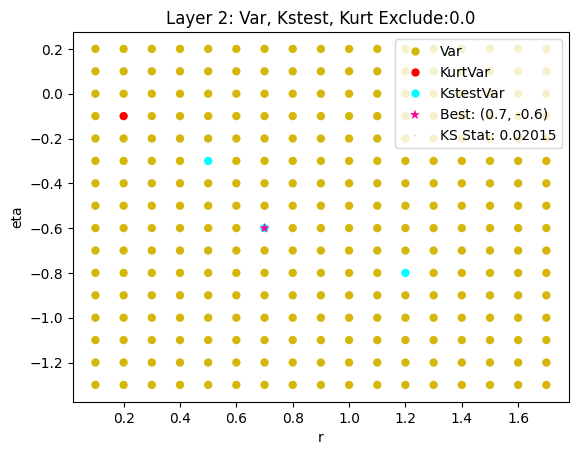

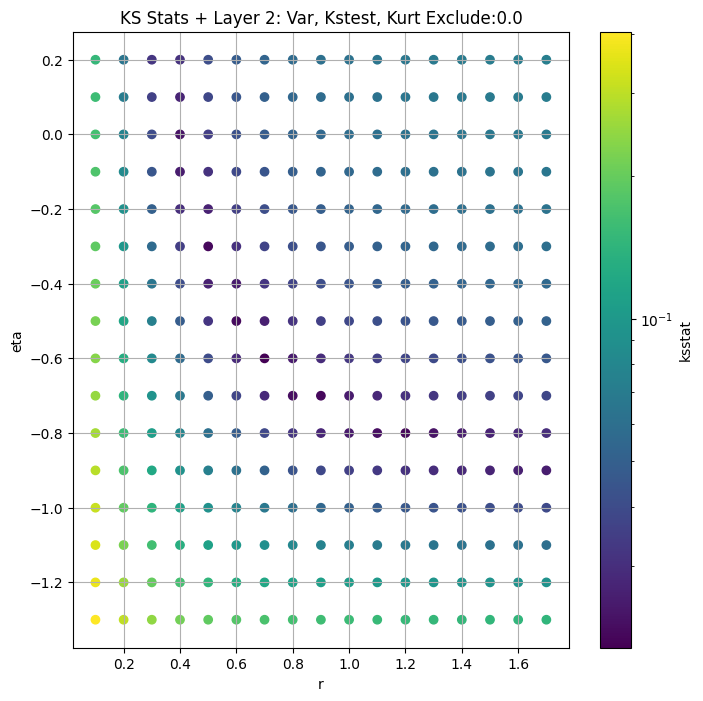

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.006798277564447619 2435.9912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.00899376590875145 2219.699


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.010763013288395351 2088.8438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.012672903709660788 1984.0472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.014338935483745652 1896.563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.017951542629944806 1747.9667


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.021703130584171948 1622.8595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.025462697993184125 1516.8015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.028939507765937345 1424.9323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.03205226555970431 1345.1565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.041584701634245214 1150.3207
Number of samples: 16000, Without approximation : 16000


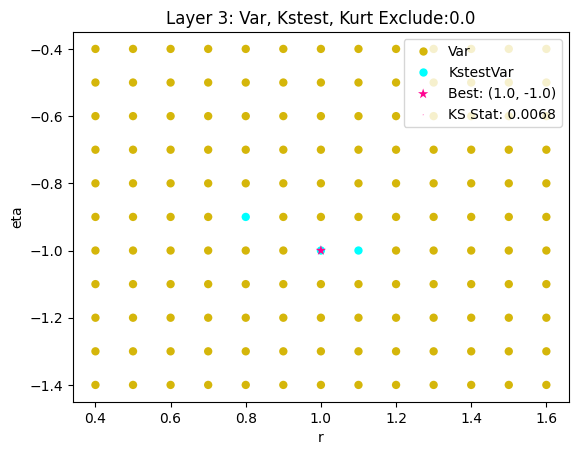

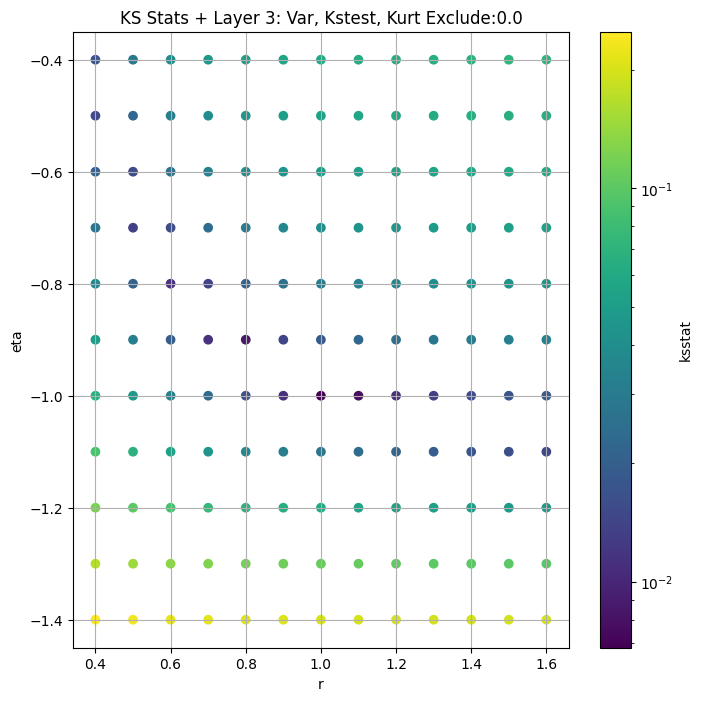

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.006498047364421833 738.67975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.006369592187412509 709.77234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.006553605247671623 689.79144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.006770988024196234 672.9043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.0067408709263966915 658.0404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.006837078029996446 632.6214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.007172439699055566 610.9962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008023114574719624 591.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.008881034982902582 574.2819


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.00969627235799685 558.1872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.012101837653090364 515.92755
Number of samples: 64000, Without approximation : 64000


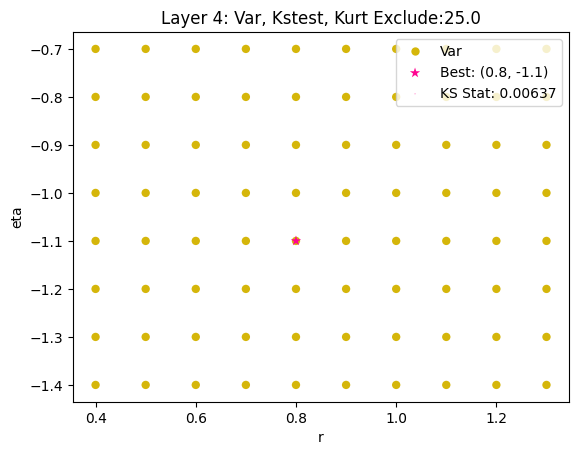

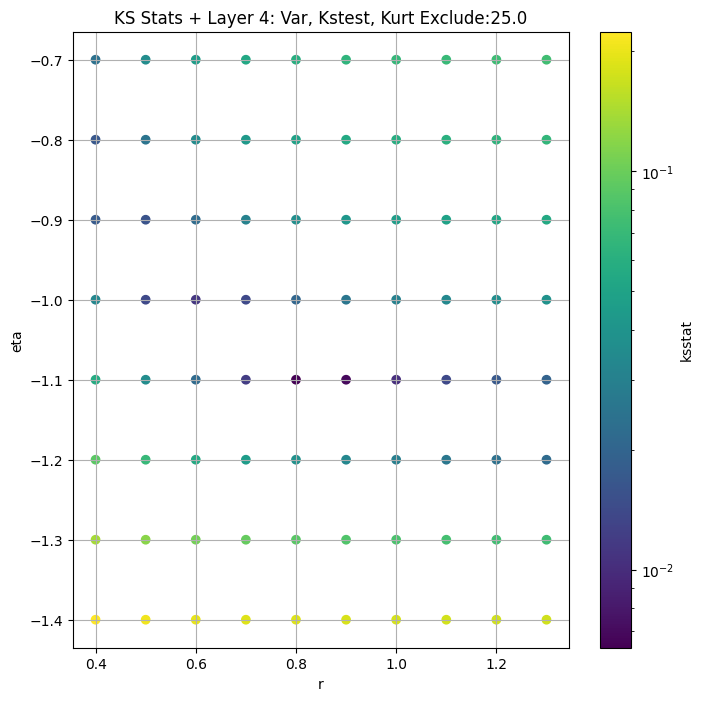

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.012129189597482548 198.20007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.012118575376803442 192.26874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.012112534056212543 187.96745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.012137088050157785 184.32938


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.012219027079947098 181.10275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.012207274101351806 175.40813


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.012196305148561515 170.33192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.012185988571250306 165.75577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.012176194032084586 161.57945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.012166793109579688 157.71744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.012140374398555809 147.57532
Number of samples: 100000, Without approximation : 256000


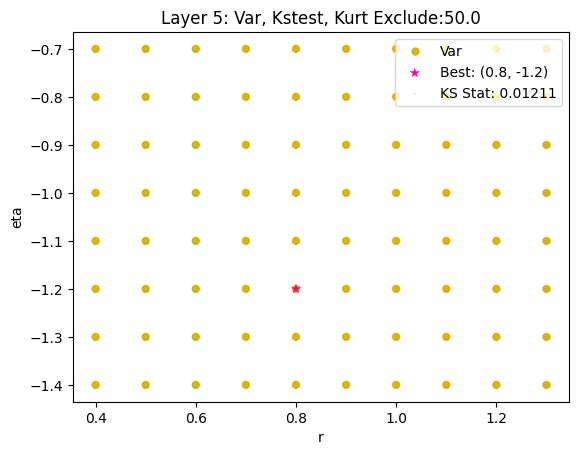

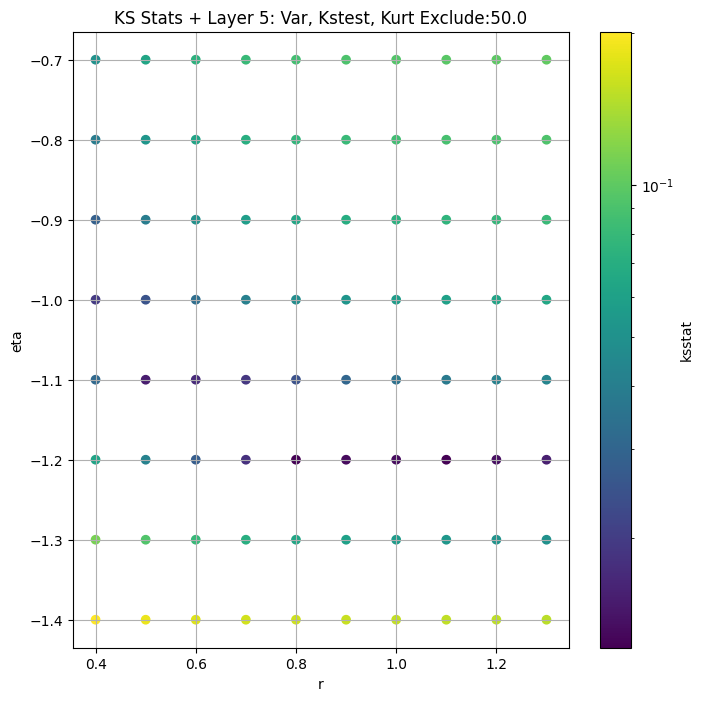

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.03245999999999982 49.50636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.03245999999999982 47.976208


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.03245999999999982 46.824604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.03245999999999982 45.829987


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.03245999999999982 44.935833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.03245999999999982 43.35114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.03245999999999982 41.957977


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.03245999999999982 40.708935


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.03245999999999982 39.570595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.03245999999999982 38.52212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.03245999999999982 35.783867
Number of samples: 100000, Without approximation : 1024000


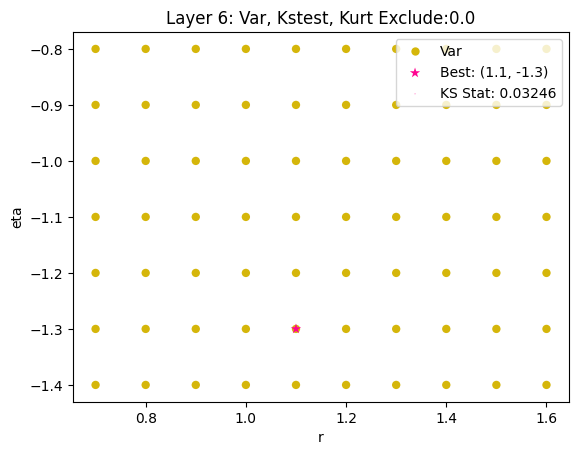

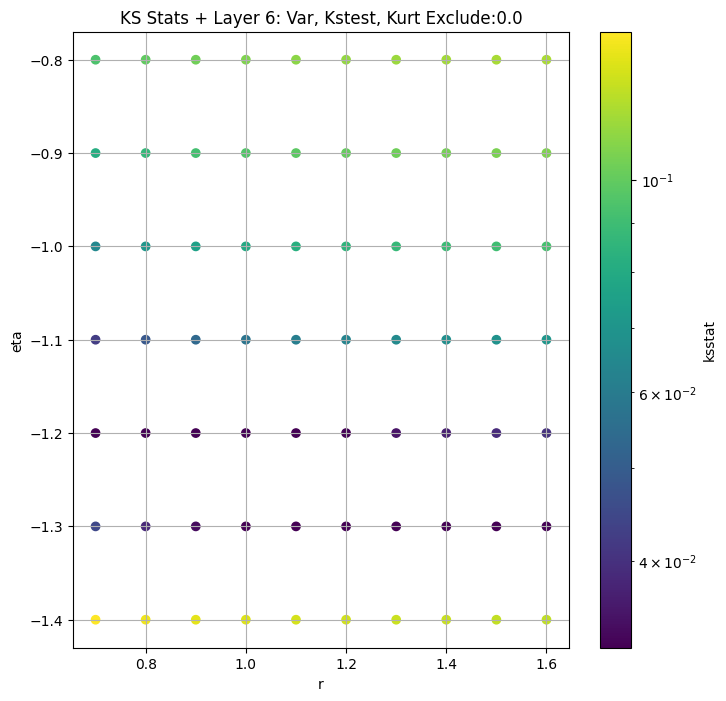

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.06765999999999978 11.688205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.06765999999999978 11.305162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.06765999999999978 11.011557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.06765999999999978 10.755934


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.06765999999999978 10.525291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.06765999999999978 10.116488


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.06765999999999978 9.758213


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.06765999999999978 9.437524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.06765999999999978 9.14525


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.06765999999999978 8.876126


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.06765999999999978 8.176299
Number of samples: 100000, Without approximation : 4096000


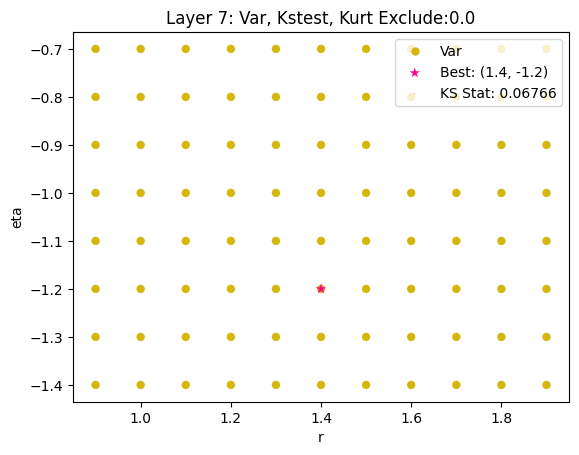

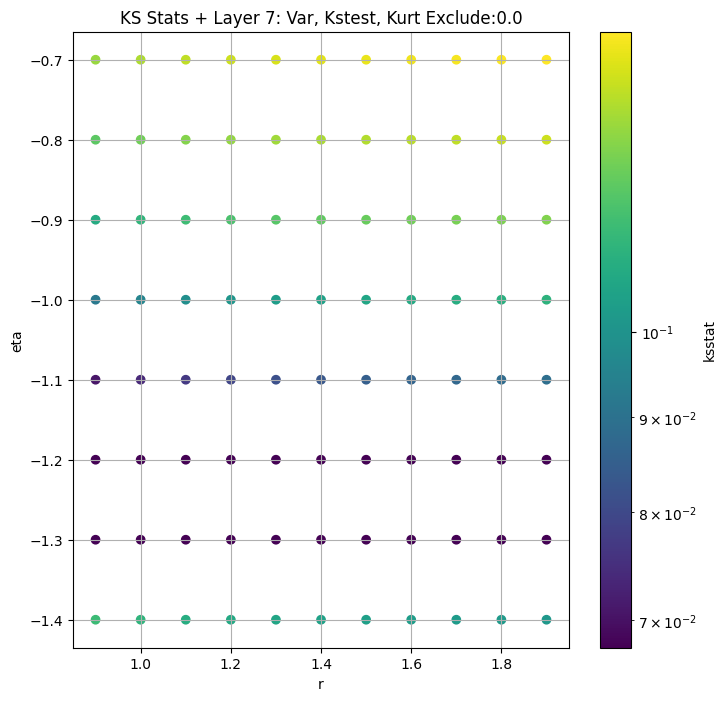

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.1122599999999998 2.688385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.1122599999999998 2.5919654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.1122599999999998 2.5197067


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.1122599999999998 2.4571269


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.1122599999999998 2.4009395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.1122599999999998 2.3017724


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.1122599999999998 2.2153323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.1122599999999998 2.1382565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.1122599999999998 2.0683284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.1122599999999998 2.0041578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.1122599999999998 1.8378687
Number of samples: 100000, Without approximation : 16384000


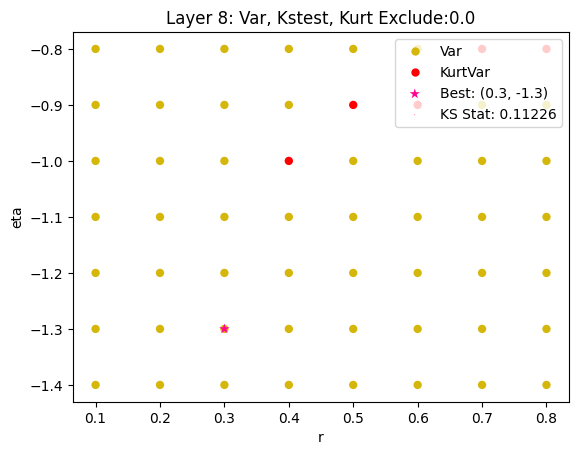

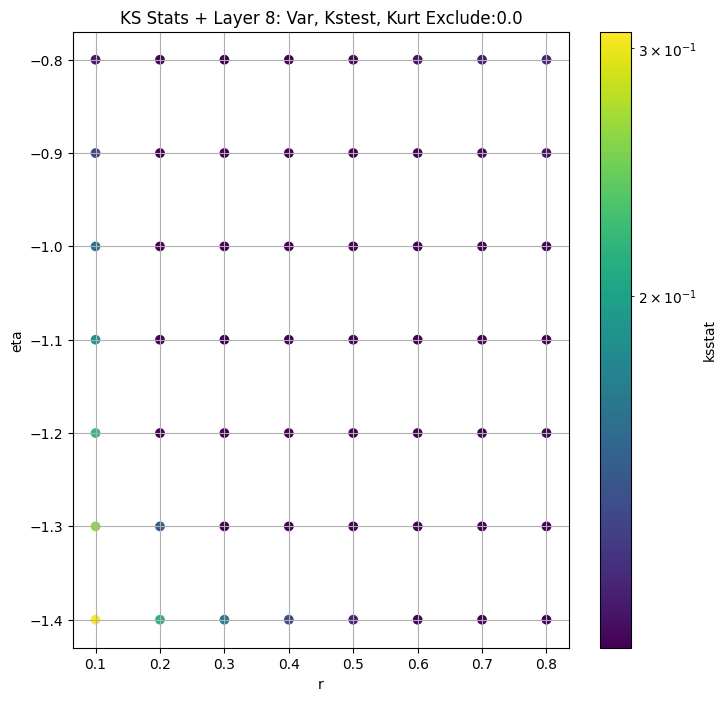

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.16035999999999978 0.6605228


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.16035999999999978 0.63462853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.16035999999999978 0.61541367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.16035999999999978 0.598954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.16035999999999978 0.584297


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.16035999999999978 0.55870724


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.16035999999999978 0.53661644


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.16035999999999978 0.5170406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.16035999999999978 0.4993945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.16035999999999978 0.4833002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.16035999999999978 0.4419531
Number of samples: 100000, Without approximation : 65536000


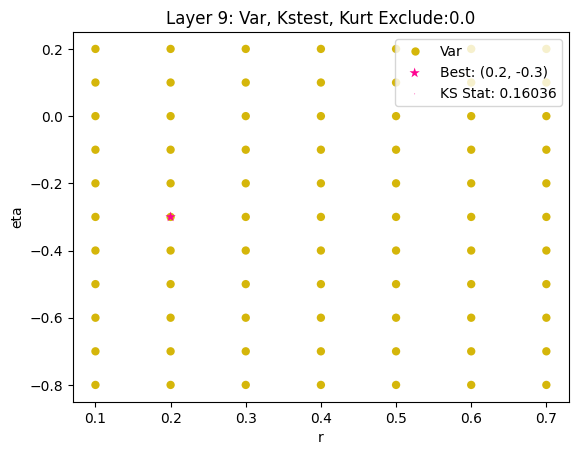

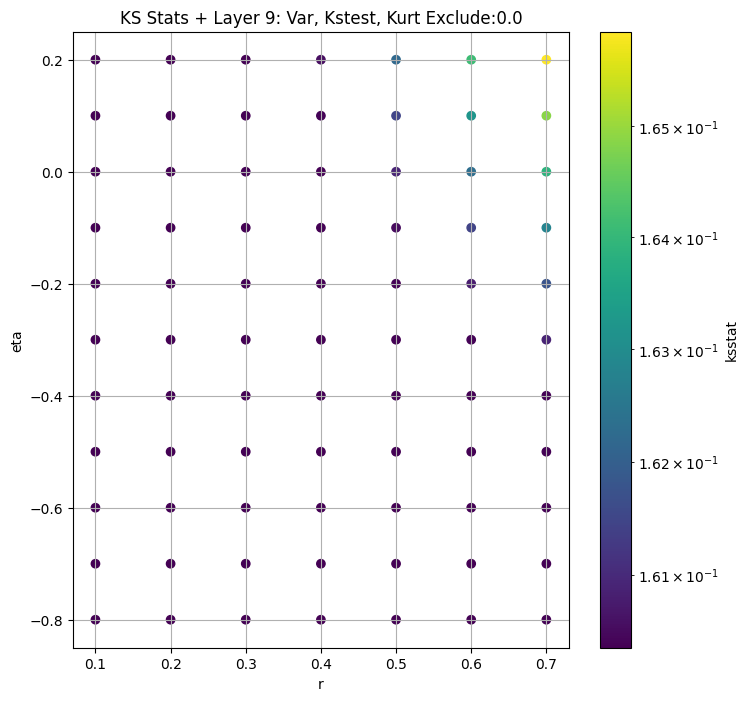

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.21063999999999983 0.19276091


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.21063999999999983 0.18503201


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.21063999999999983 0.17923193


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.21063999999999983 0.17430356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.21063999999999983 0.16995396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.21063999999999983 0.16245012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.21063999999999983 0.1560684


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.21063999999999983 0.15048324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.21063999999999983 0.14549986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.21063999999999983 0.14099365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.21063999999999983 0.1295731
Number of samples: 100000, Without approximation : 262144000


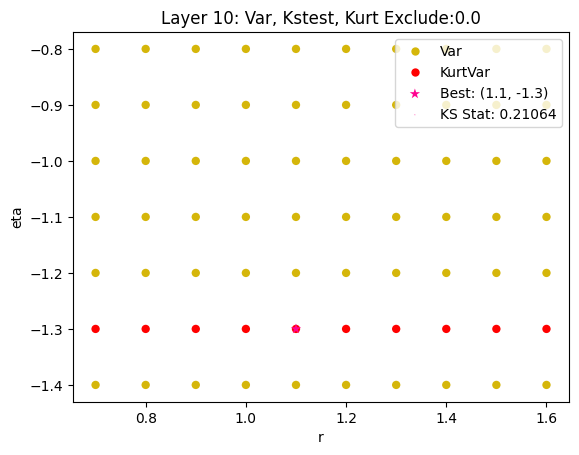

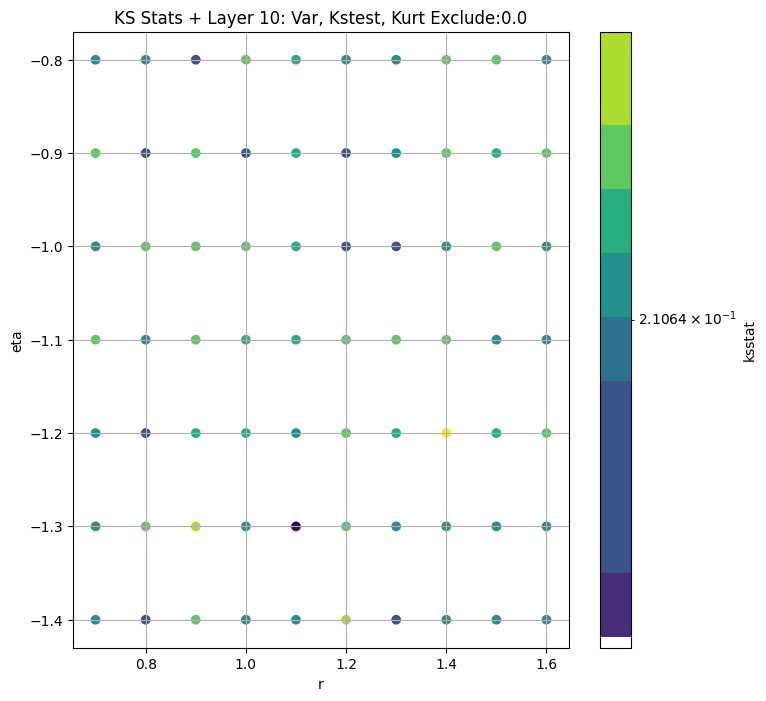

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      9030.142000  8175.746000  9933.516000   3.730290    2.927670   
3      2435.991200  2272.371600  2608.602800   5.225170    4.214867   
4       738.679750   680.785950   798.848700   7.656179    6.244269   
5       198.200070   181.349260   215.927780   9.336671    7.684987   
6        49.506360    45.094315    54.224213  10.842089    9.090936   
7        11.688205    10.574771    12.871078  12.554486   10.613249   
8         2.688385     2.419825     2.973556  13.938999   11.662300   
9         0.660523     0.592600     0.732903  15.165461   12.488104   
10        0.192761     0.173248     0.213634  14.628241   11.787691   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.566437           4000             0.020149        0.7         -0.6   
3        6.392464          16000             0.006798        1.0         -1.0   
4        9.261974          64000             0.006370        0.8         -1.1   
5       11.315386         256000             0.012113        0.8         -1.2   
6       12.832723        1024000             0.032460        1.1         -1.3   
7       14.772611        4096000             0.067660        1.4         -1.2   
8       16.595562       16384000             0.112260        0.3         -1.3   
9       18.324146       65536000             0.160360        0.2         -0.3   
10      17.827797      262144000             0.210640        1.1         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5200.100070                     0.0         9030.142000   
3        4871.982422                     0.0         2435.991200   
4        1368.828212                    25.0          709.772340   
5         496.963678                    50.0          187.967450   
6         263.196800                     0.0           49.506360   
7          47.658986                     0.0           11.688205   
8           0.606732                     0.0            2.688385   
9           0.000022                     0.0            0.660523   
10          1.024799                     0.0            0.192761   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.021431  
3                     0.010726  
4                     0.005366  
5                     0.002684  
6                     0.001342  
7                     0.000671  
8                     0.000336  
9                     0.000168  
10                    0.000084

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.04940140277554628, var: 5043.4931640625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.040493919707152326, var: 5570.36865234375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.03130793959478462, var: 6259.1796875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.024477667098953715, var: 7243.06298828125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.019805085878863926, var: 9030.1416015625
Number of samples: 4000, Without approximation : 4000


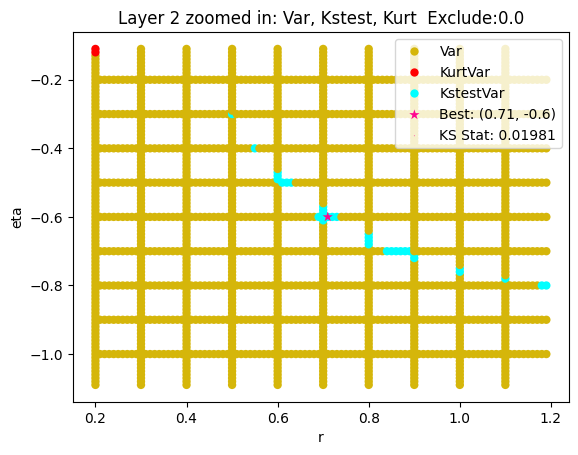

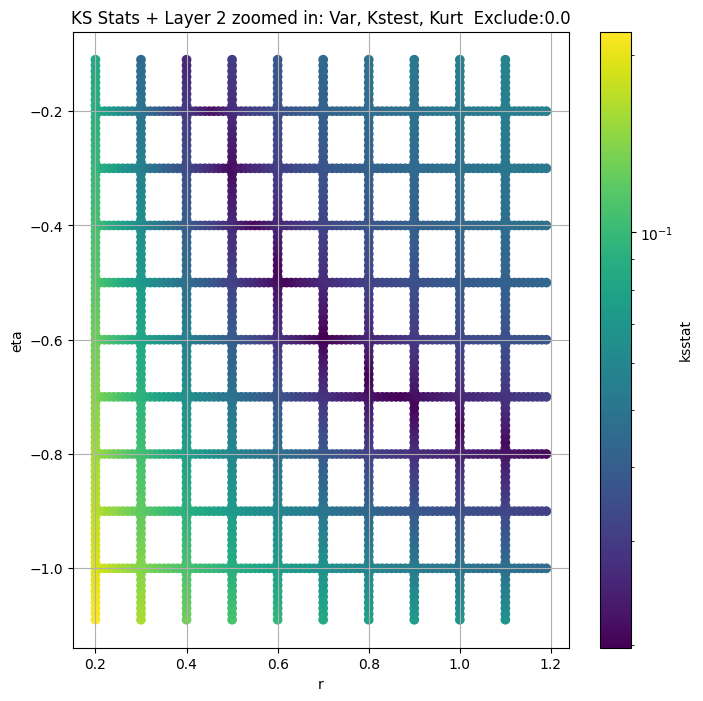

Layer 3


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.016071533982500052, var: 1896.56298828125


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.013965706846423953, var: 1984.0472412109375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.011387295637598438, var: 2088.84375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.008606917261644309, var: 2219.698974609375


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.006008940982697941, var: 2435.9912109375
Number of samples: 16000, Without approximation : 16000


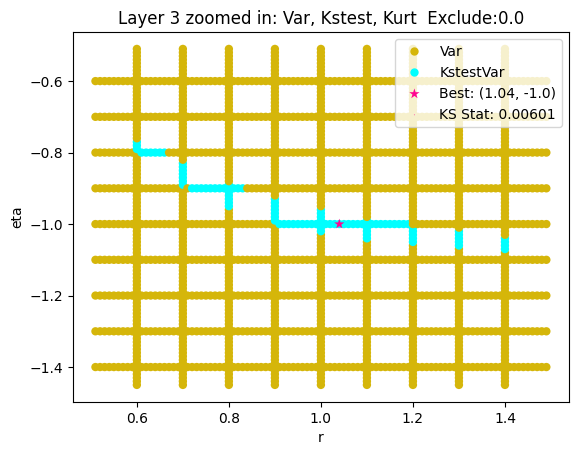

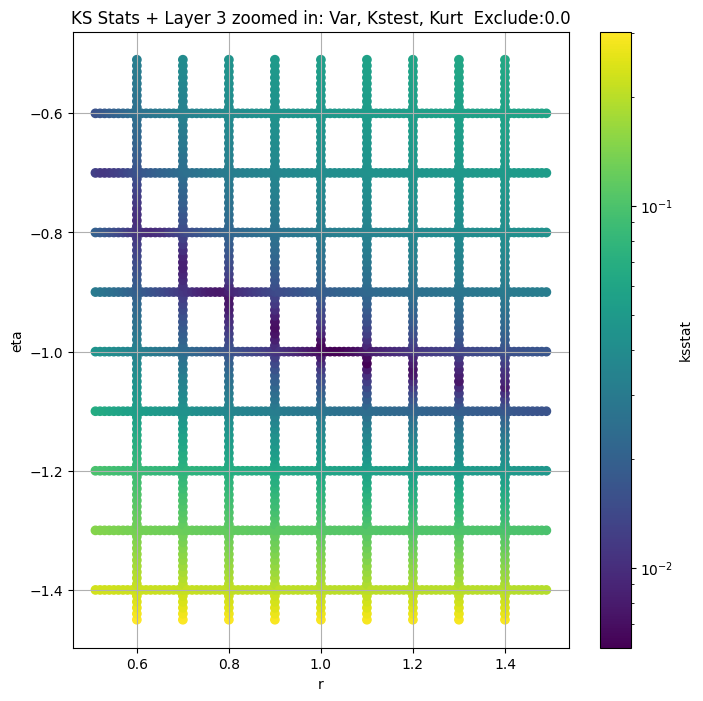

Layer 4


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.006249477670969117, var: 644.7777099609375


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.0061047775713874985, var: 658.0404052734375


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.006140608000974879, var: 672.904296875


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.006227712719513667, var: 689.7914428710938


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.005964811309683848, var: 709.7723388671875


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.0062802810450204305, var: 738.6797485351562
Number of samples: 64000, Without approximation : 64000


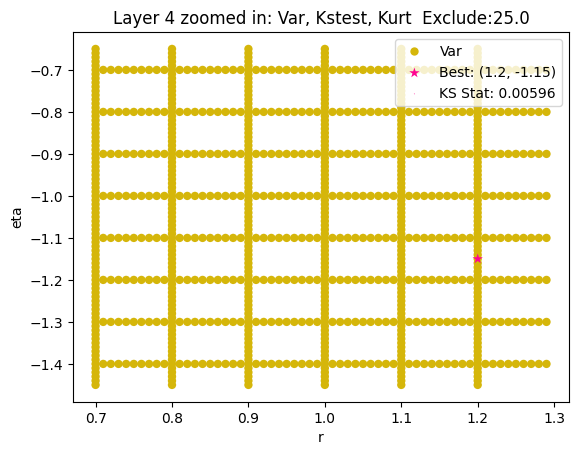

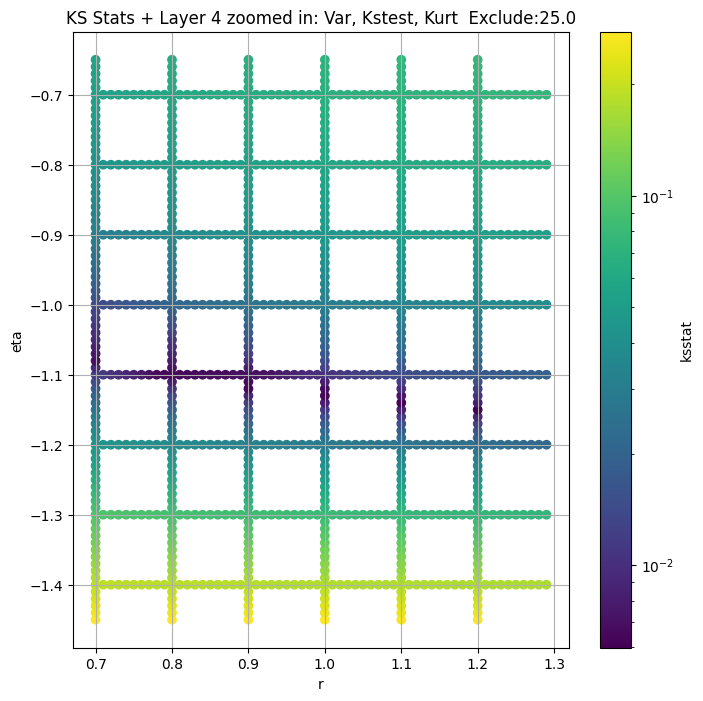

Layer 5


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.012110089886265829, var: 175.4081268310547


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.012110416605824625, var: 178.1575927734375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.012110852077515222, var: 181.10275268554688


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.01211150427540686, var: 184.32937622070312


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.011999999999999955, var: 187.9674530029297


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.011999999999999955, var: 192.26873779296875


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.011999999999999955, var: 198.2000732421875
Number of samples: 100000, Without approximation : 256000


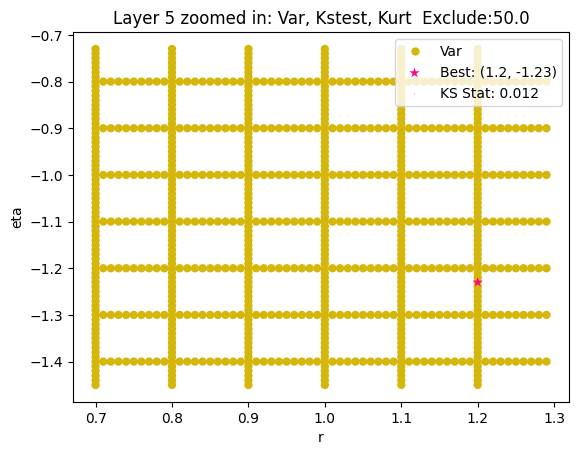

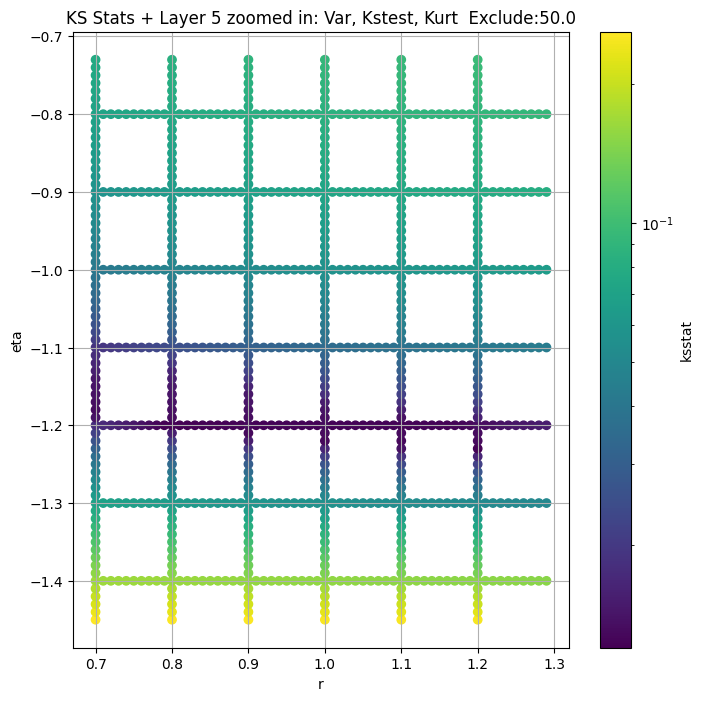

Layer 6


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.03245999999999982, var: 44.93583297729492


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.03245999999999982, var: 45.829986572265625


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.03245999999999982, var: 46.82460403442383


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.03245999999999982, var: 47.9762077331543


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.03245999999999982, var: 49.5063591003418
Number of samples: 100000, Without approximation : 1024000


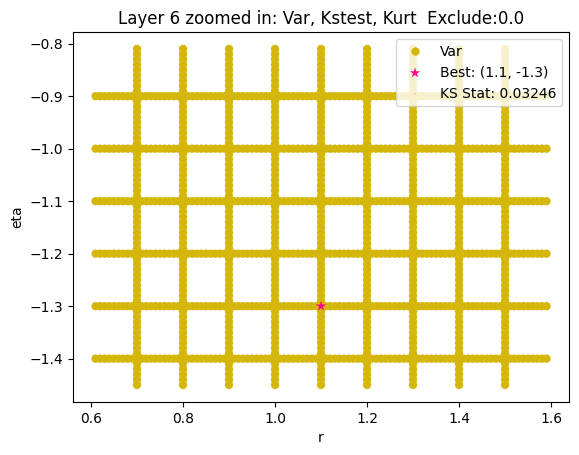

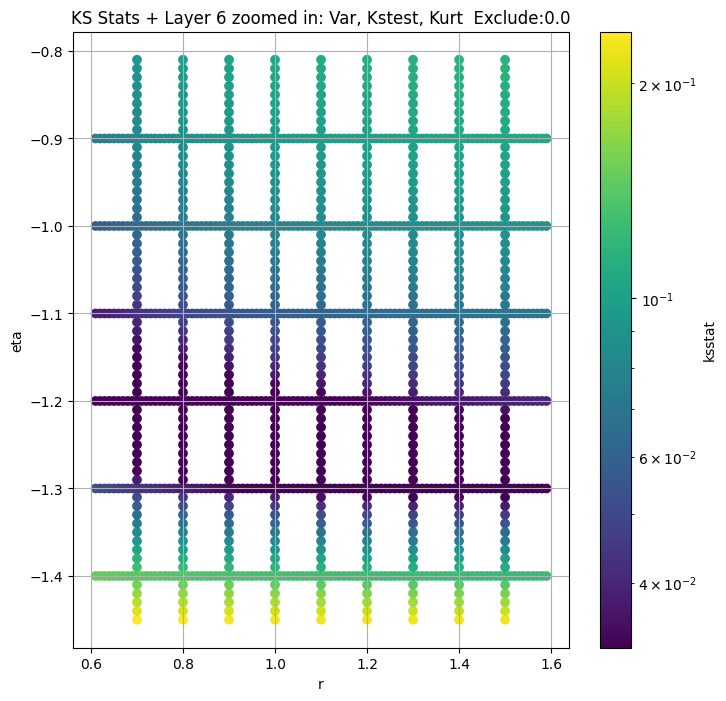

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.06765999999999972, var: 10.525291442871094


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.06765999999999972, var: 10.75593376159668


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.06765999999999972, var: 11.011556625366211


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.06765999999999972, var: 11.30516242980957


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.06765999999999972, var: 11.688204765319824
Number of samples: 100000, Without approximation : 4096000


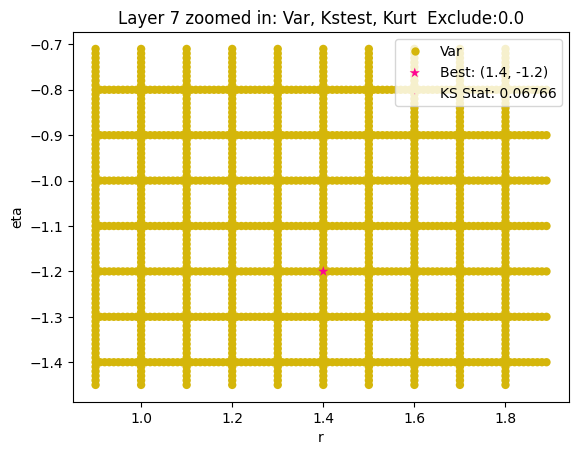

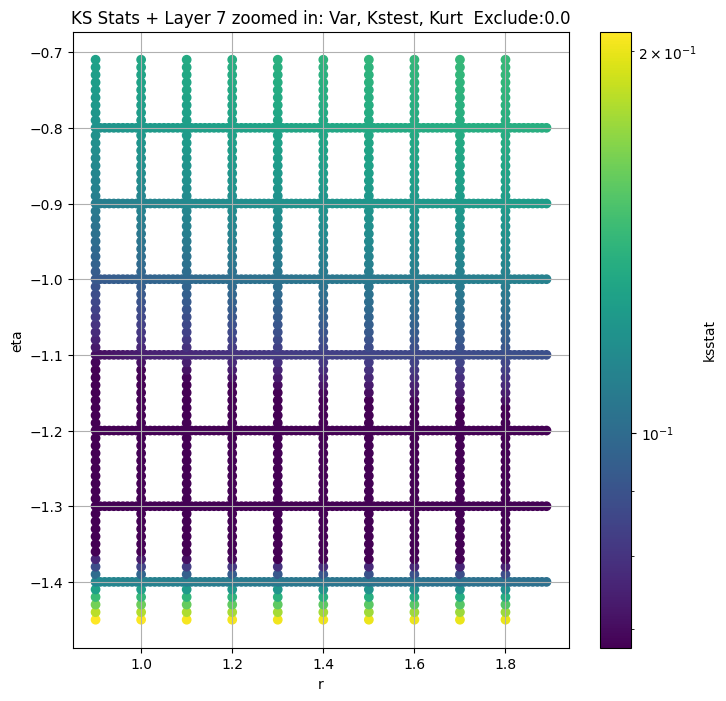

Layer 8


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.1122599999999998, var: 2.400939464569092


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.1122599999999998, var: 2.4571268558502197


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.1122599999999998, var: 2.5197067260742188


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.1122599999999998, var: 2.591965436935425


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.1122599999999998, var: 2.688385009765625
Number of samples: 100000, Without approximation : 16384000


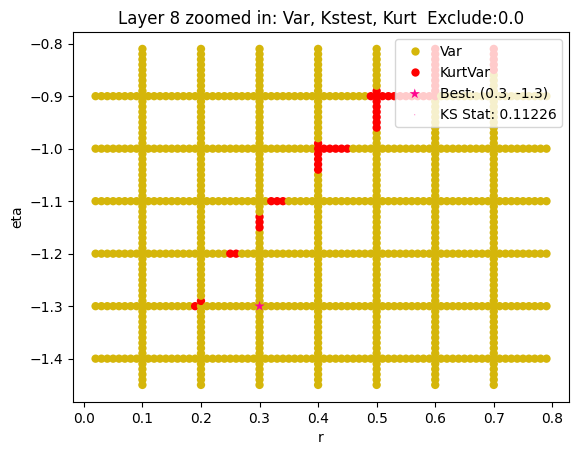

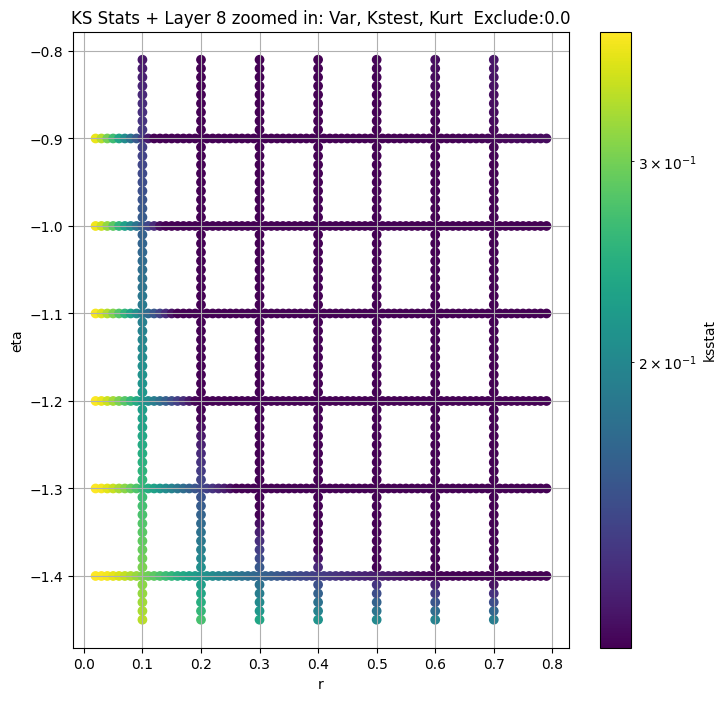

Layer 9


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.16035999999999978, var: 0.5842970013618469


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.16035999999999978, var: 0.5989540219306946


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.16035999999999978, var: 0.6154136657714844


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.16035999999999978, var: 0.6346285343170166


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.16035999999999978, var: 0.6605228185653687
Number of samples: 100000, Without approximation : 65536000


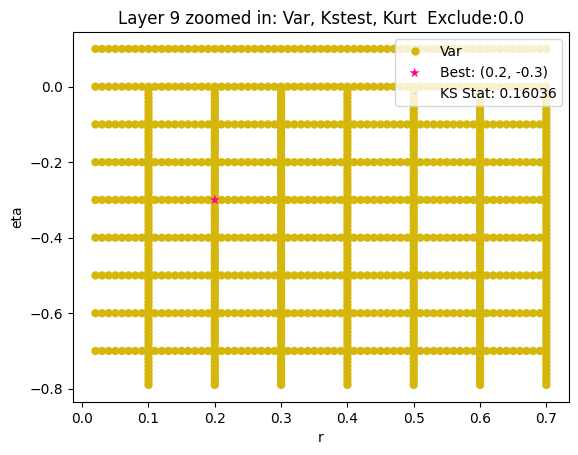

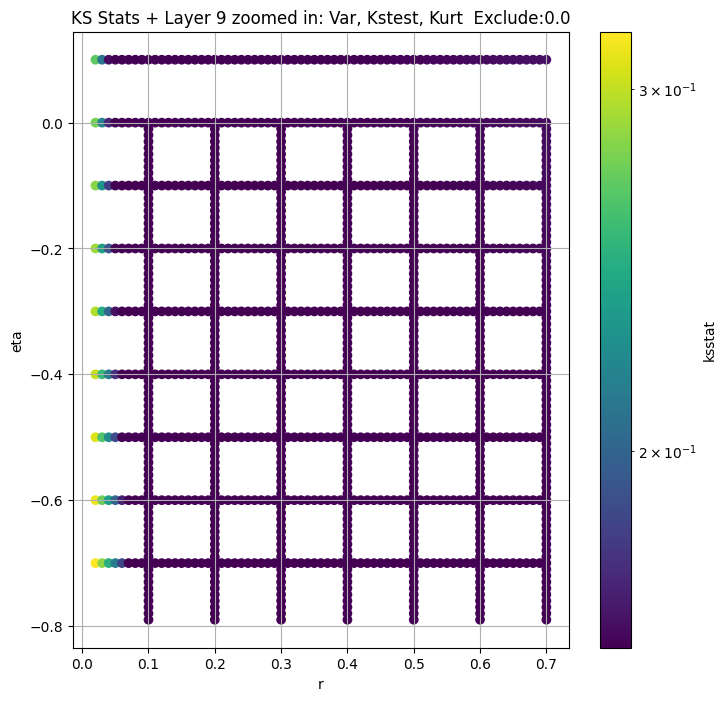

Layer 10


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 10, 0.0 + 100 = 100, ksstat: 0.21063999999999983, var: 0.16995395720005035


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 10, 0.0 + 75 = 75, ksstat: 0.21063999999999983, var: 0.1743035614490509


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 10, 0.0 + 50 = 50, ksstat: 0.21063999999999983, var: 0.1792319267988205


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 10, 0.0 + 25 = 25, ksstat: 0.21063999999999983, var: 0.18503201007843018


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 10, 0.0 + 0 = 0, ksstat: 0.21063999999999983, var: 0.1927609145641327
Number of samples: 100000, Without approximation : 262144000


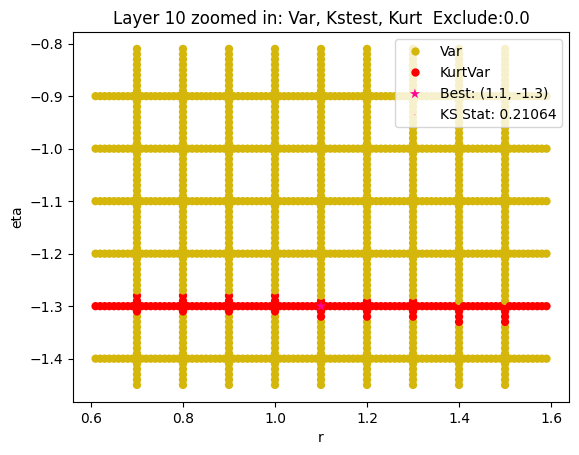

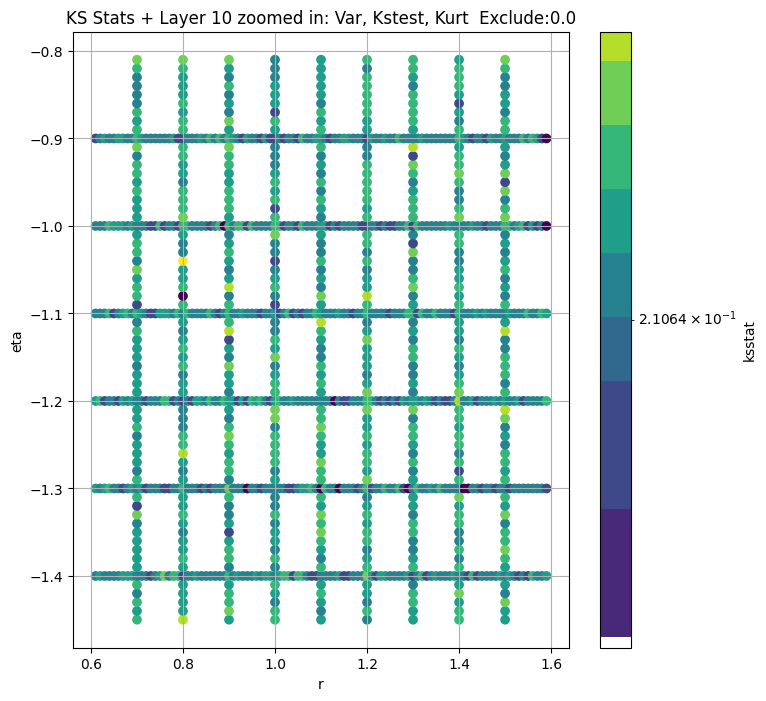

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      9030.142000  8175.746000  9933.516000   3.730290    2.927670   
3      2435.991200  2272.371600  2608.602800   5.225170    4.214867   
4       738.679750   680.785950   798.848700   7.656179    6.244269   
5       198.200070   181.349260   215.927780   9.336671    7.684987   
6        49.506360    45.094315    54.224213  10.842089    9.090936   
7        11.688205    10.574771    12.871078  12.554486   10.613249   
8         2.688385     2.419825     2.973556  13.938999   11.662300   
9         0.660523     0.592600     0.732903  15.165461   12.488104   
10        0.192761     0.173248     0.213634  14.628241   11.787691   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.566437           4000             0.020149        0.7         -0.6   
3        6.392464          16000             0.006798        1.0         -1.0   
4        9.261974          64000             0.006370        0.8         -1.1   
5       11.315386         256000             0.012113        0.8         -1.2   
6       12.832723        1024000             0.032460        1.1         -1.3   
7       14.772611        4096000             0.067660        1.4         -1.2   
8       16.595562       16384000             0.112260        0.3         -1.3   
9       18.324146       65536000             0.160360        0.2         -0.3   
10      17.827797      262144000             0.210640        1.1         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5200.100070                     0.0         9030.141602   
3        4871.982422                     0.0         2435.991211   
4        1368.828212                    25.0          709.772339   
5         496.963678                    50.0          187.967453   
6         263.196800                     0.0           49.506360   
7          47.658986                     0.0           11.688205   
8           0.606732                     0.0            2.688385   
9           0.000022                     0.0            0.660523   
10          1.024799                     0.0            0.192761   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.021431          0.019805    0.71     -0.60   
3                     0.010726          0.006009    1.04     -1.00   
4                     0.005366          0.005965    1.20     -1.15   
5                     0.002684          0.012000    1.20     -1.23   
6                     0.001342          0.032460    1.10     -1.30   
7                     0.000671          0.067660    1.40     -1.20   
8                     0.000336          0.112260    0.30     -1.30   
9                     0.000168          0.160360    0.20     -0.30   
10                    0.000084          0.210640    1.10     -1.30   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      5379.550498                  0.0         4500  
3      5066.833412                  0.0        54000  
4      2322.468132                 25.0        54000  
5       785.770409                 50.0        13500  
6       263.196800                  0.0         1687  
7        47.658986                  0.0          421  
8         0.606732                  0.0          139  
9         0.000022                  0.0           69  
10        1.024799                  0.0           40

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

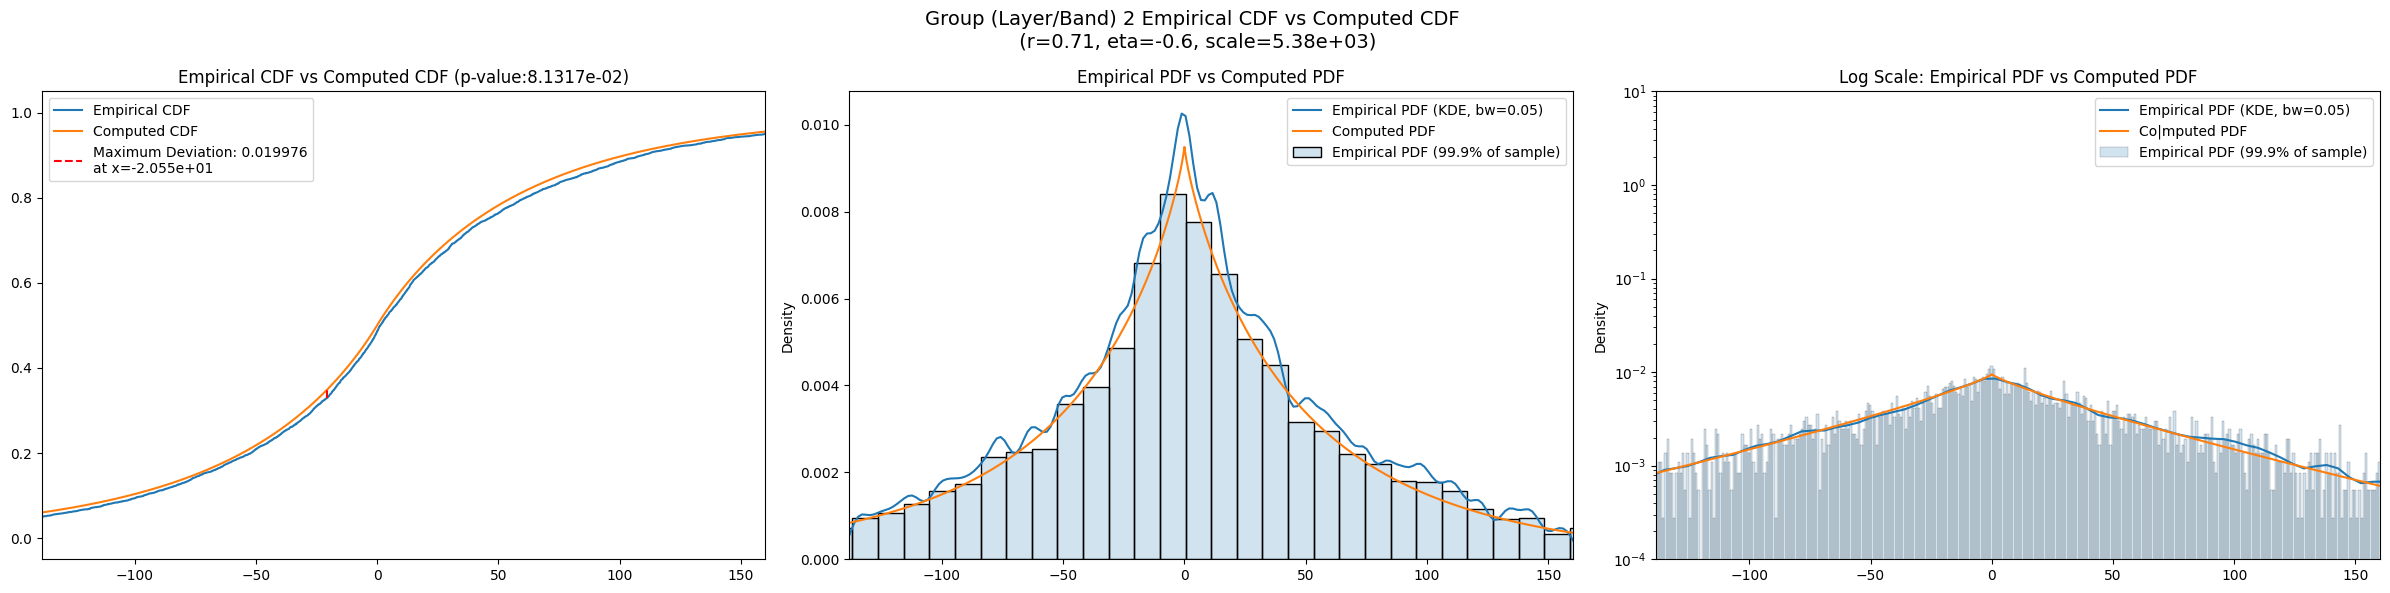

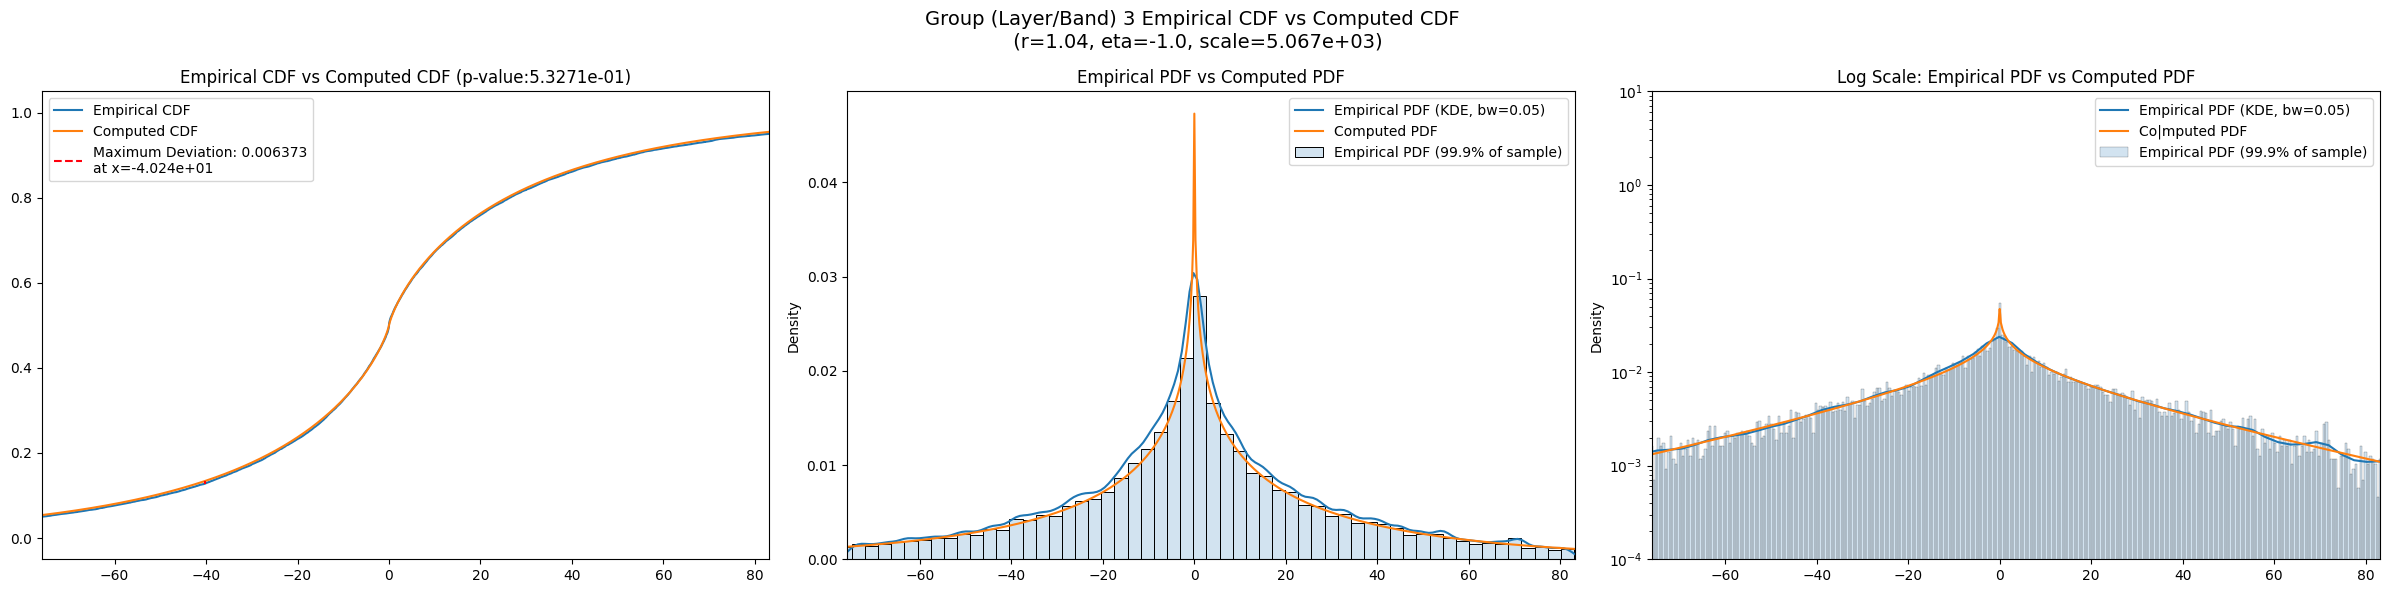

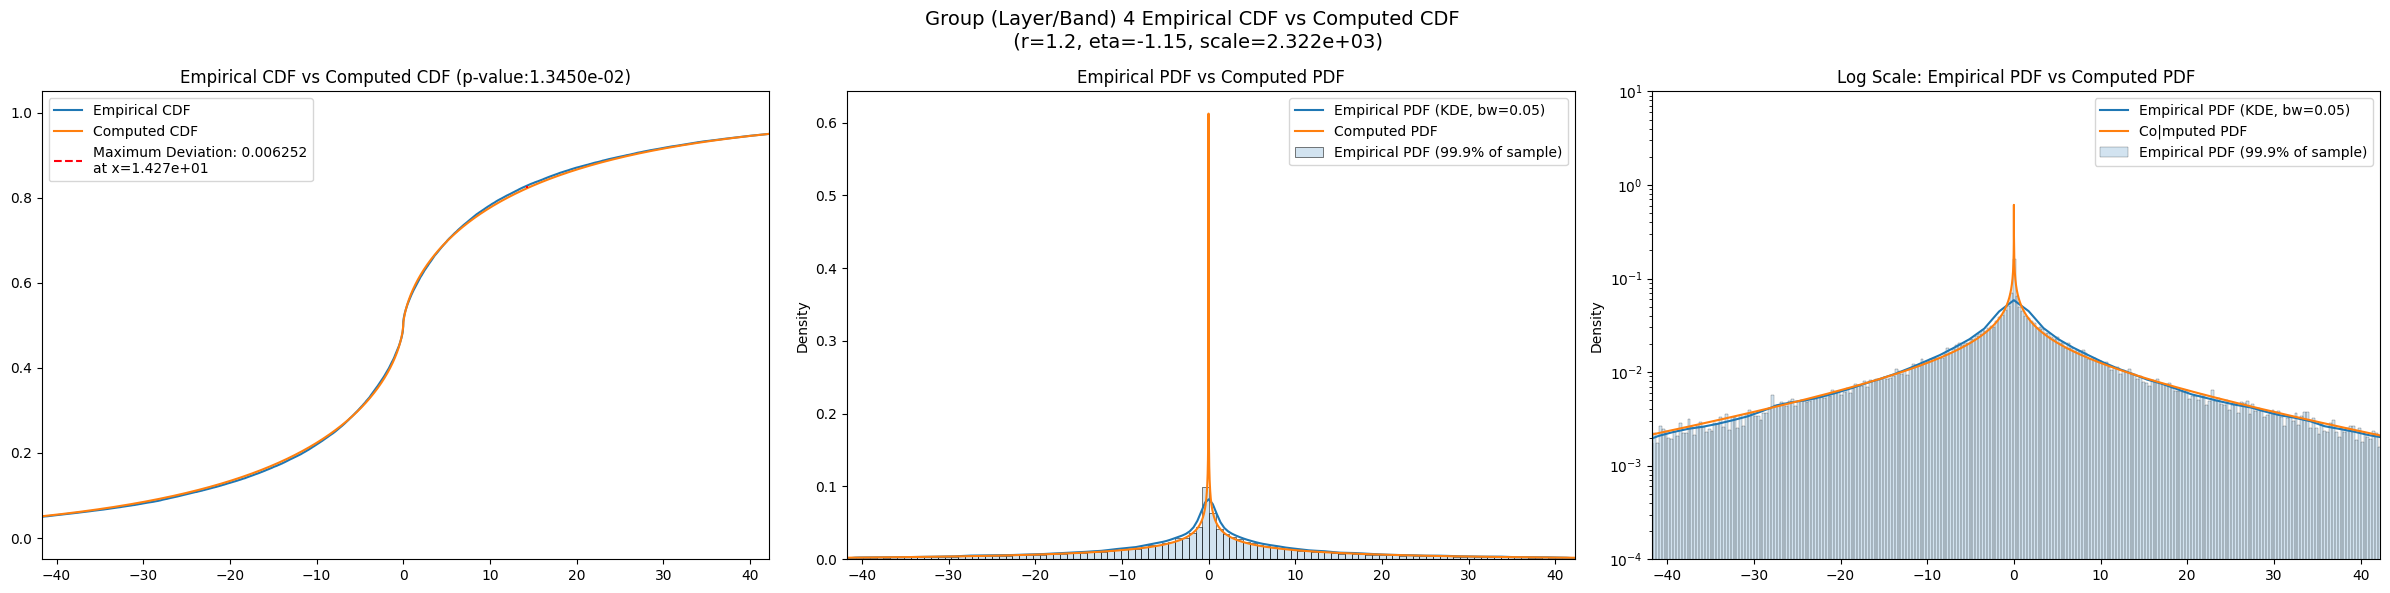

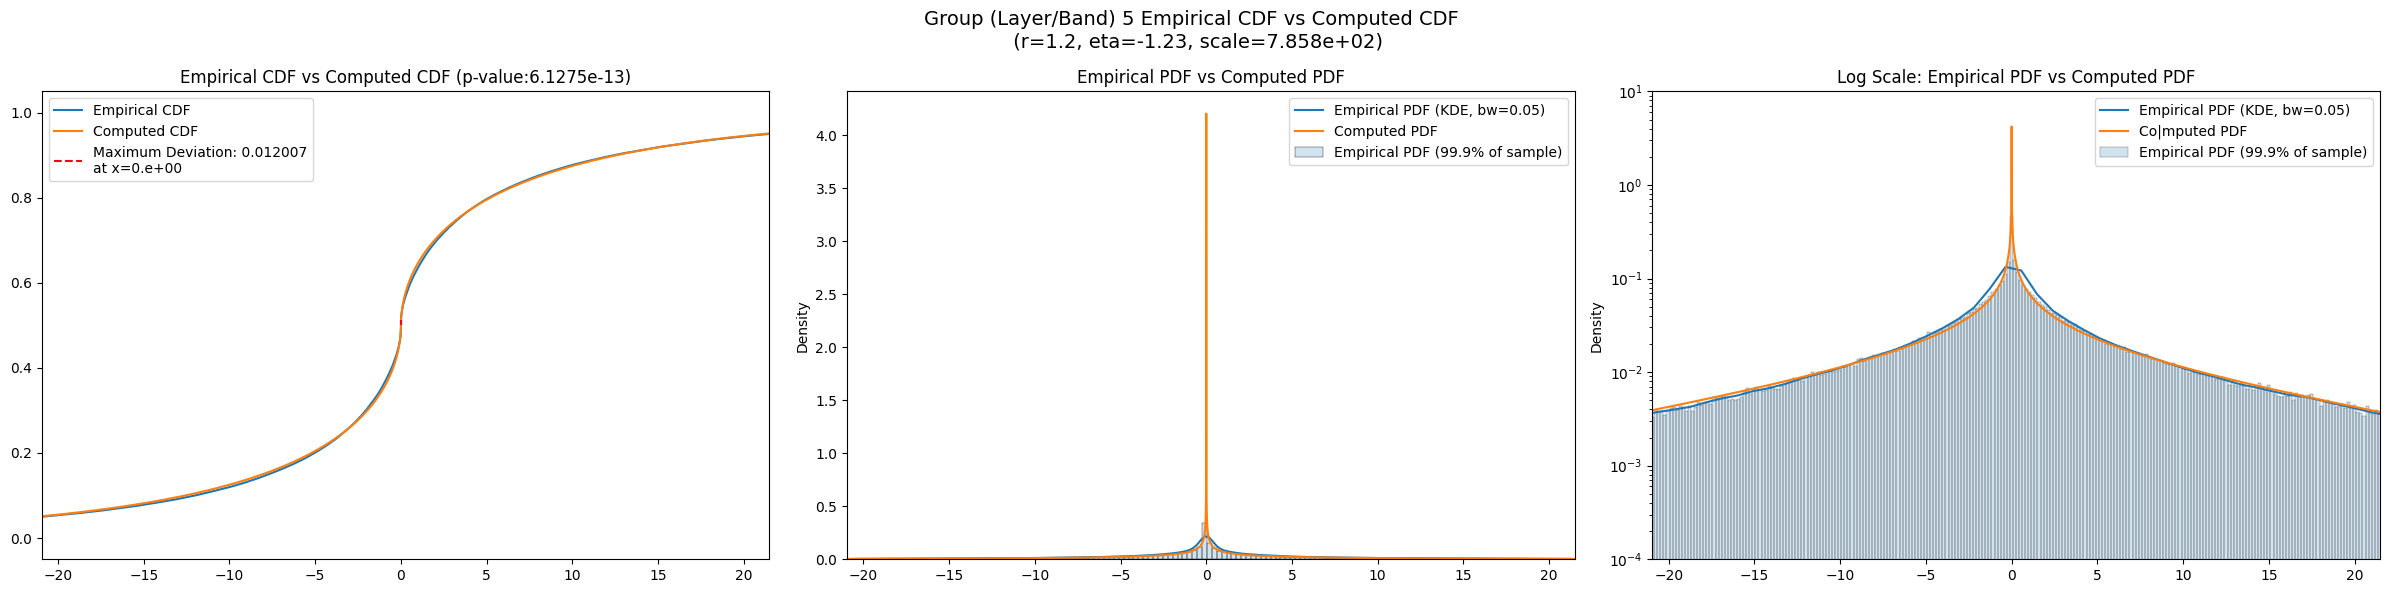

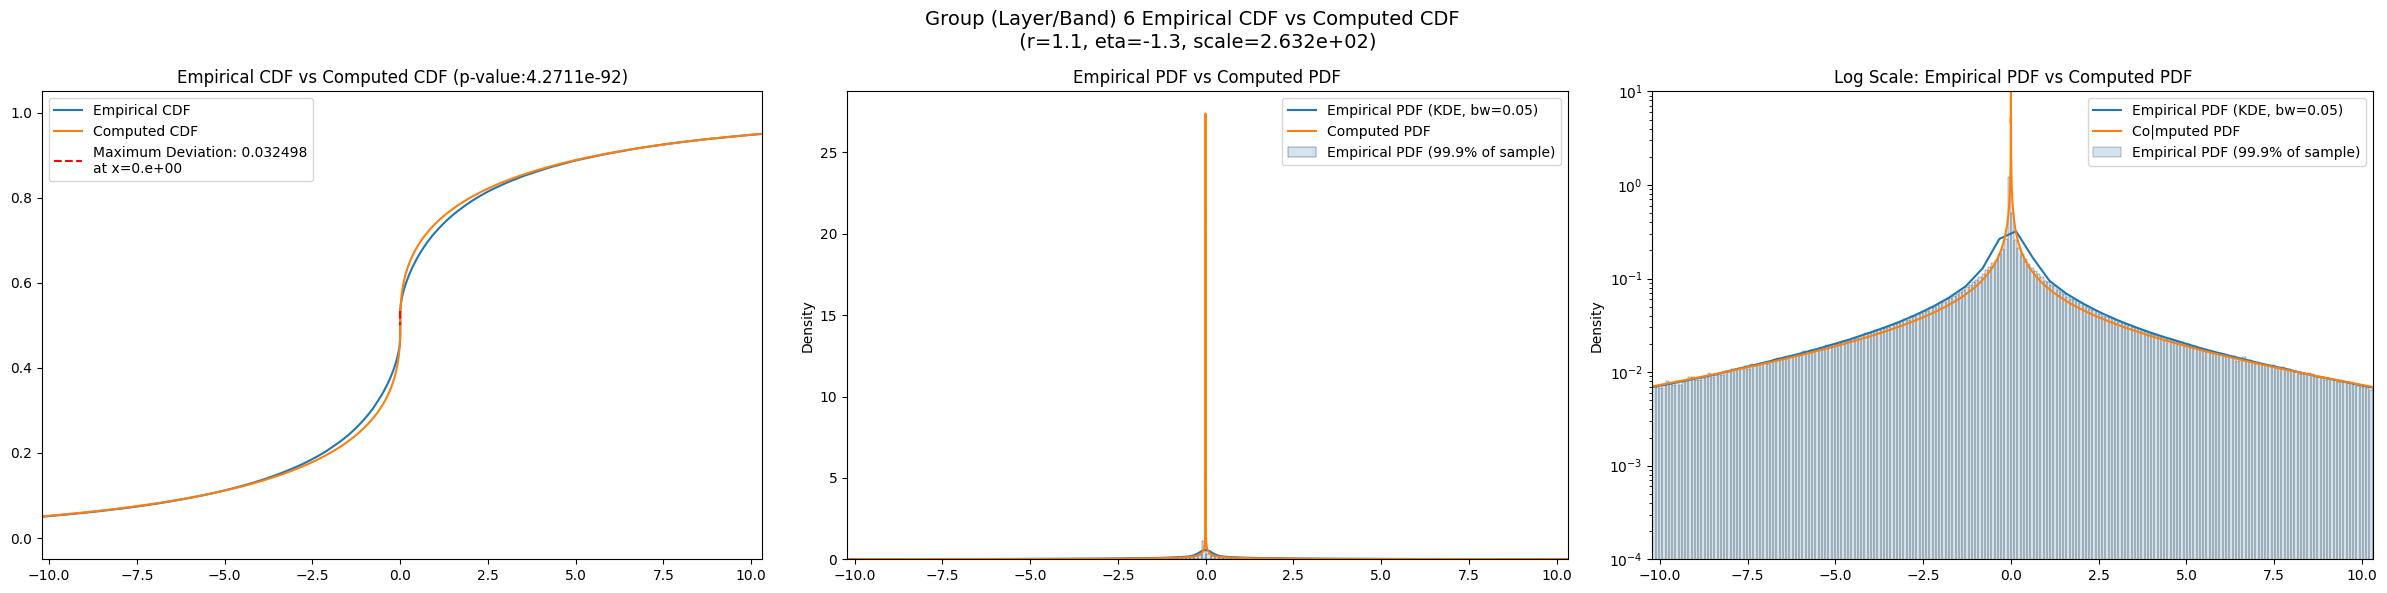

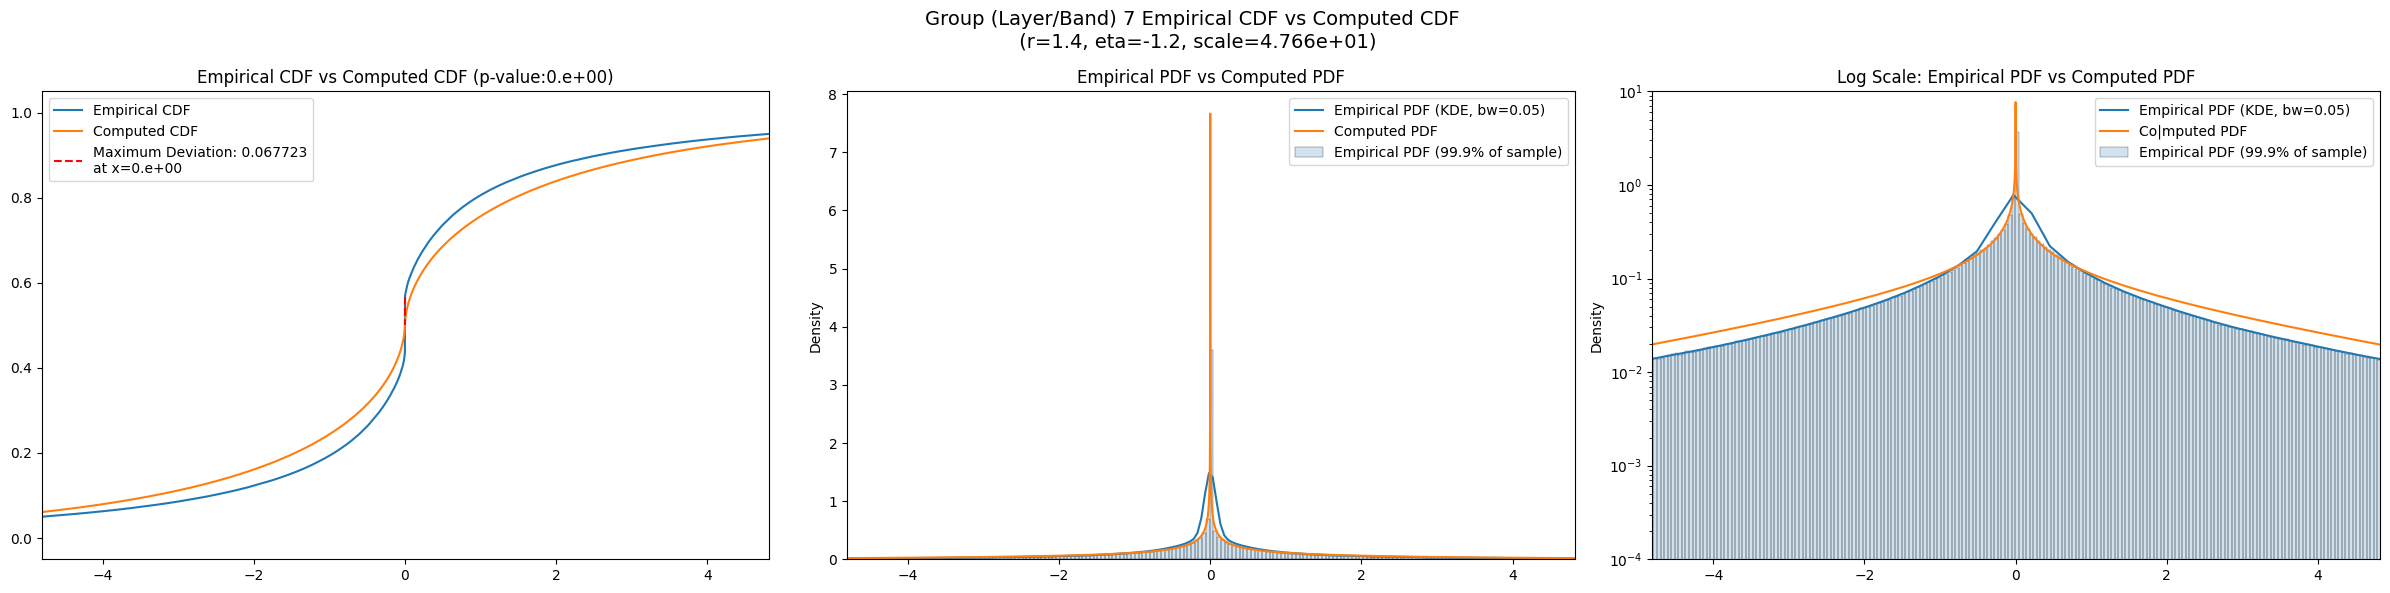

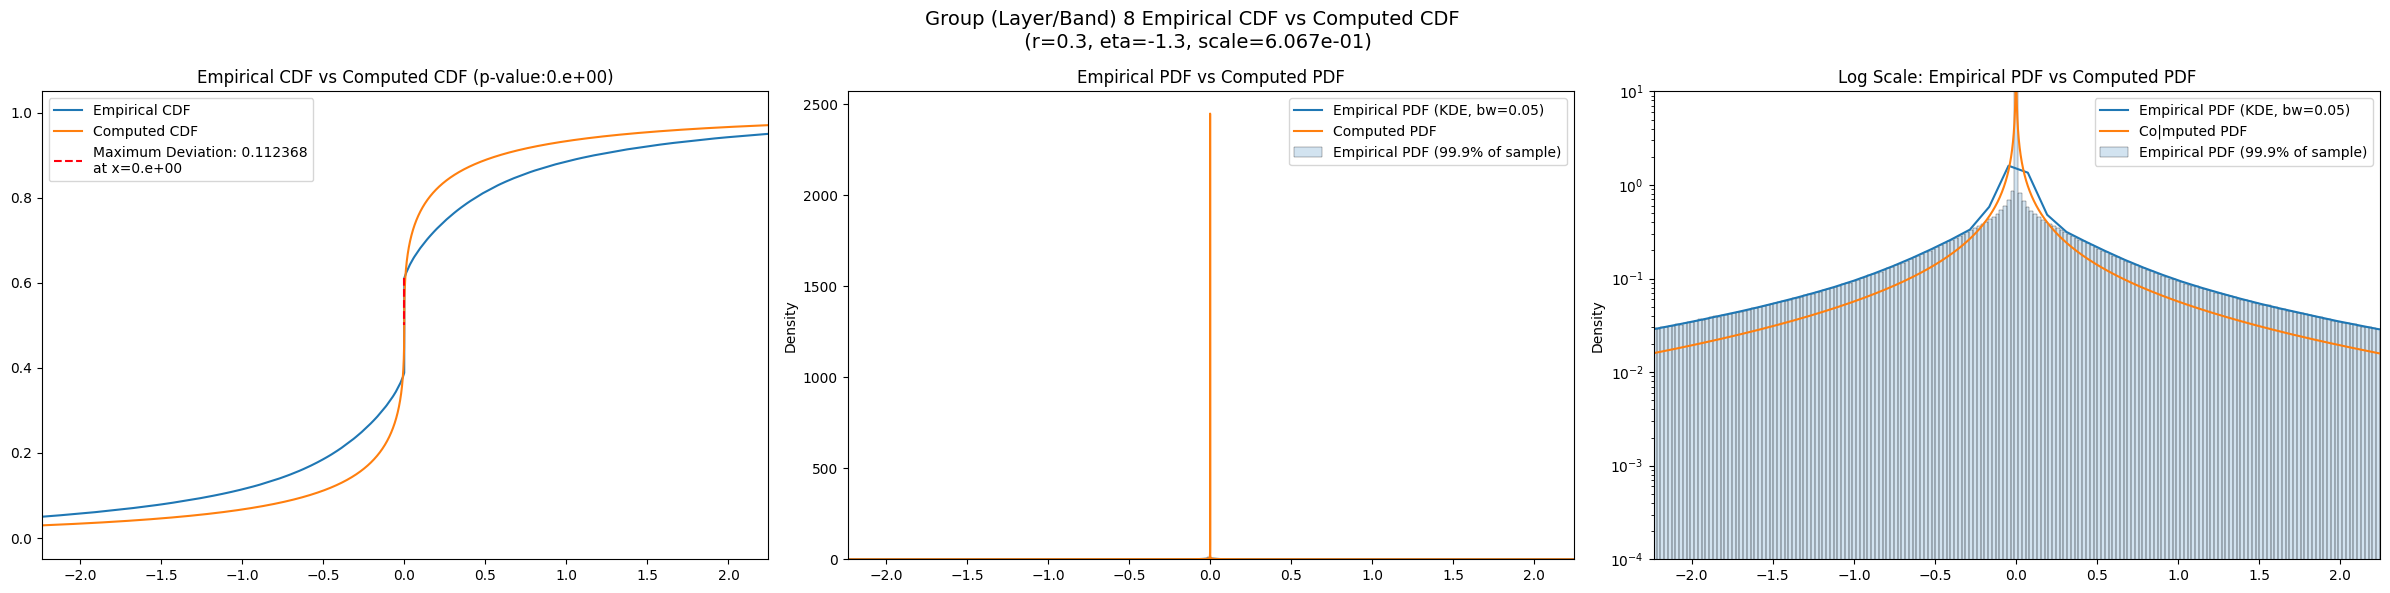

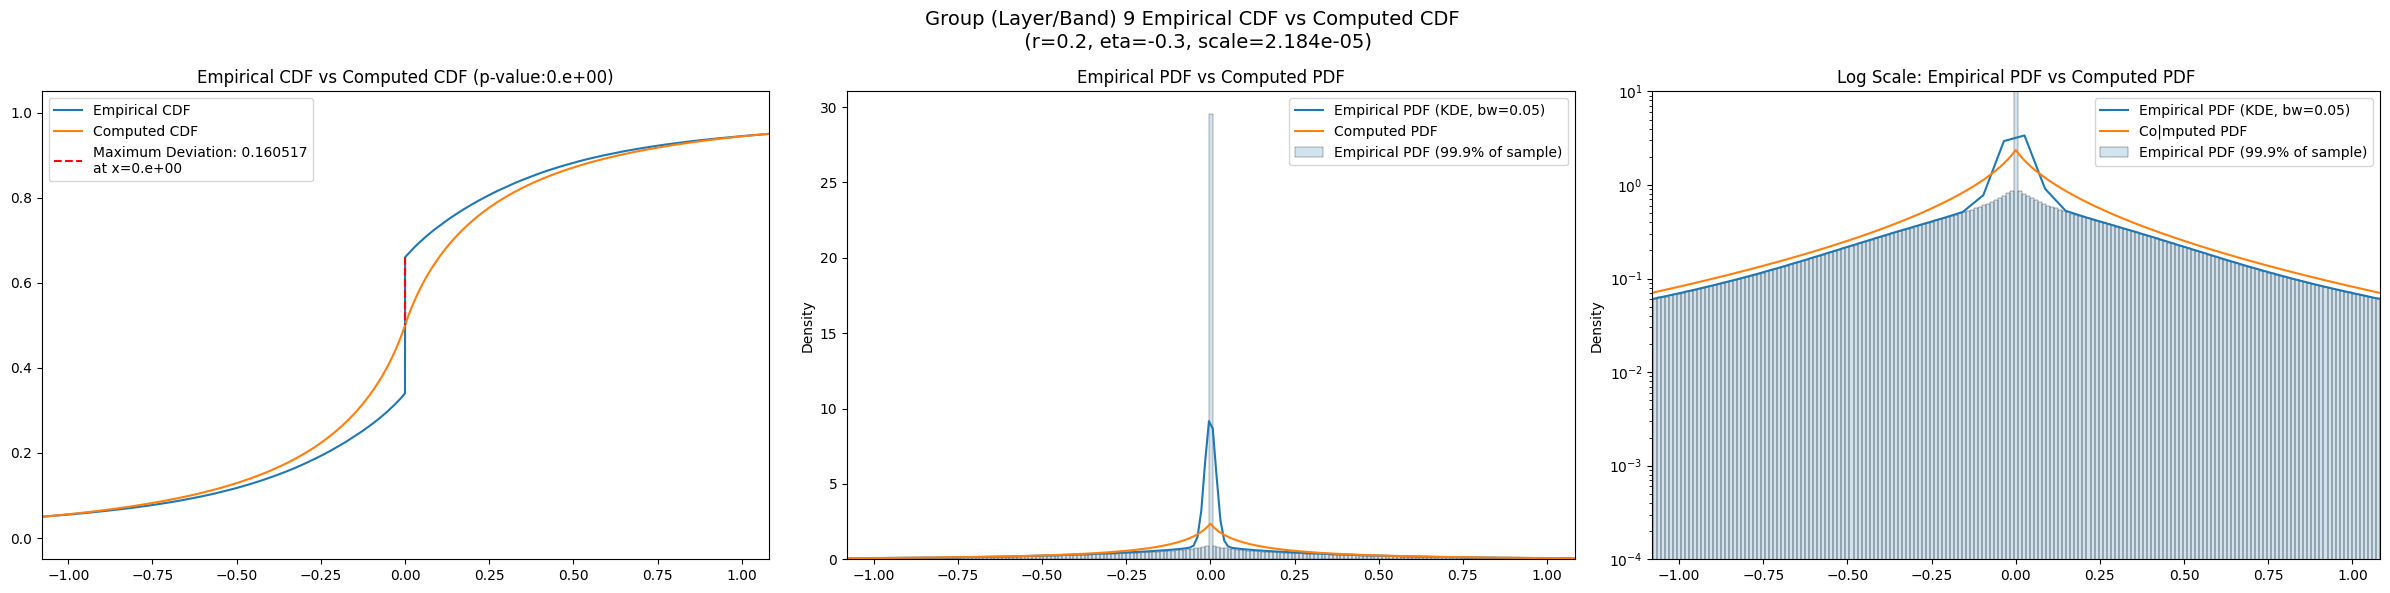

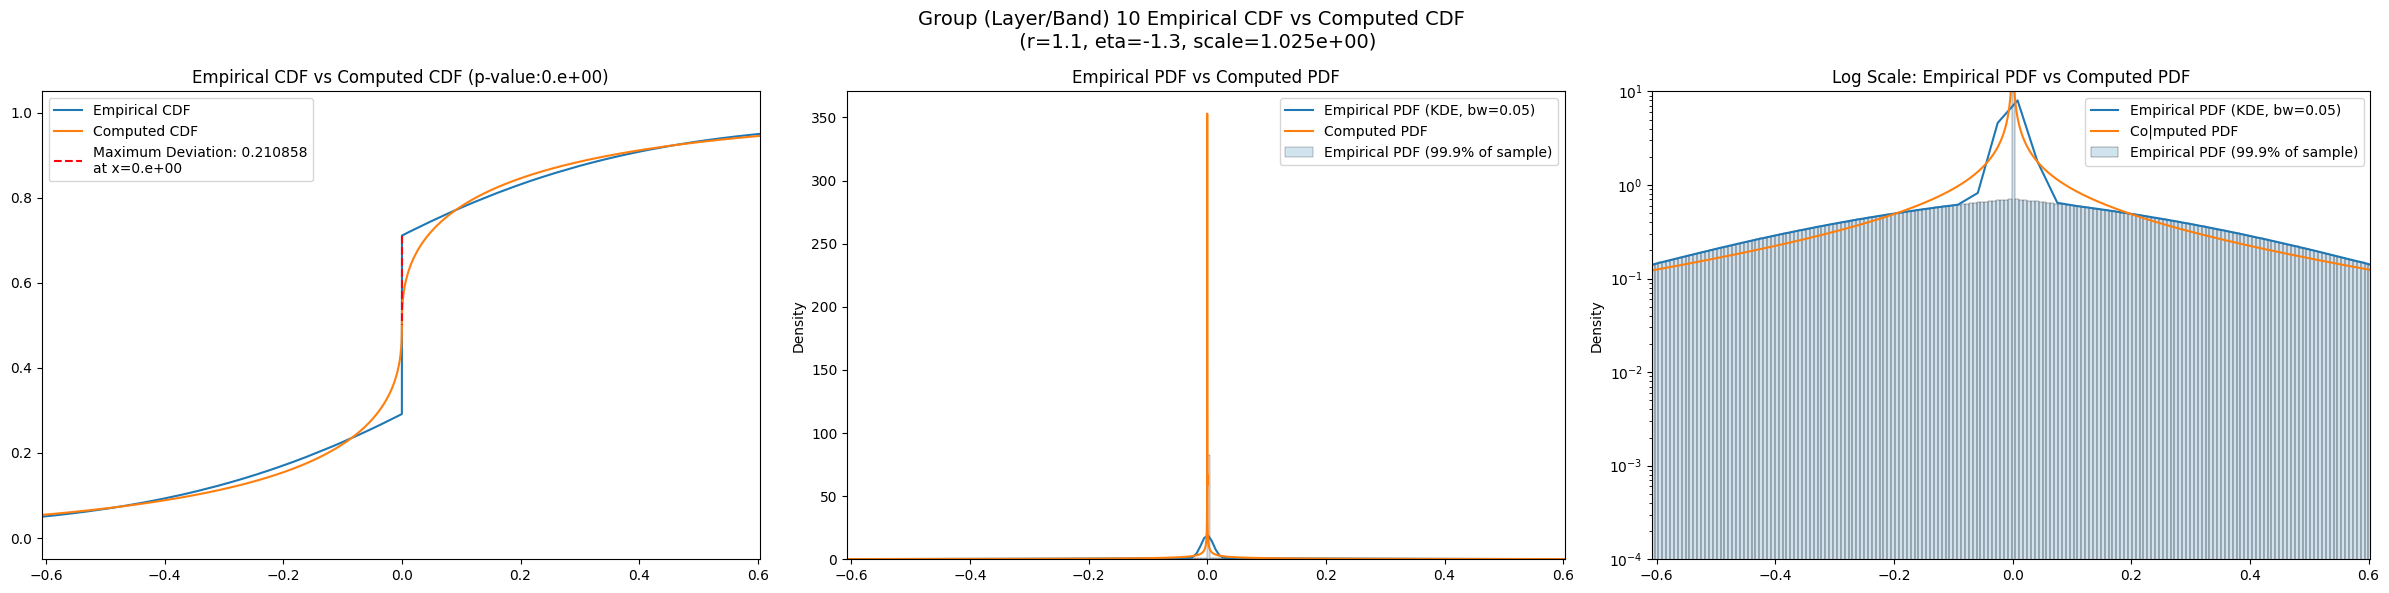

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      9030.142000  8175.746000  9933.516000   3.730290    2.927670   
3      2435.991200  2272.371600  2608.602800   5.225170    4.214867   
4       738.679750   680.785950   798.848700   7.656179    6.244269   
5       198.200070   181.349260   215.927780   9.336671    7.684987   
6        49.506360    45.094315    54.224213  10.842089    9.090936   
7        11.688205    10.574771    12.871078  12.554486   10.613249   
8         2.688385     2.419825     2.973556  13.938999   11.662300   
9         0.660523     0.592600     0.732903  15.165461   12.488104   
10        0.192761     0.173248     0.213634  14.628241   11.787691   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        4.566437           4000             0.020149        0.7         -0.6   
3        6.392464          16000             0.006798        1.0         -1.0   
4        9.261974          64000             0.006370        0.8         -1.1   
5       11.315386         256000             0.012113        0.8         -1.2   
6       12.832723        1024000             0.032460        1.1         -1.3   
7       14.772611        4096000             0.067660        1.4         -1.2   
8       16.595562       16384000             0.112260        0.3         -1.3   
9       18.324146       65536000             0.160360        0.2         -0.3   
10      17.827797      262144000             0.210640        1.1         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       67.217000              0.050428          2.797380e-09   
3      ...       32.286500              0.054412          1.298820e-41   
4      ...       14.480700              0.064790         5.171100e-234   
5      ...        6.278210              0.076852          0.000000e+00   
6      ...        2.636800              0.085241          0.000000e+00   
7      ...        1.071680              0.094623          0.000000e+00   
8      ...        0.404914              0.113386          0.000000e+00   
9      ...        0.323688              0.160360          0.000000e+00   
10     ...        0.126888              0.210640          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          60.029900             0.025579         1.047480e-02  50.129200   
3          28.080500             0.027188         1.044810e-10  22.543600   
4          12.411300             0.039177         8.747740e-86   9.811730   
5           5.331550             0.052743         0.000000e+00   4.150770   
6           2.181640             0.063661         0.000000e+00   1.685750   
7           0.833699             0.078897         0.000000e+00   0.645265   
8           0.332194             0.112260         0.000000e+00   0.221395   
9           0.332194             0.160360         0.000000e+00   0.289561   
10          0.112600             0.210640         0.000000e+00   0.095525   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.031319   7.646430e-04          8.559176e-02  
3           0.030942   9.640460e-14          6.080281e-01  
4           0.042178   2.284240e-99          2.096380e-02  
5           0.054838   0.000000e+00          1.891886e-32  
6           0.065655   0.000000e+00          0.000000e+00  
7           0.080595   0.000000e+00          0.000000e+00  
8           0.112260   0.000000e+00          0.000000e+00  
9           0.160360   0.000000e+00          0.000000e+00  
10          0.210640   0.000000e+00          0.000000e+00  

[9 rows x 30 

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.020149                 0.021431          0.019805   
3                 0.006798                 0.010726          0.006009   
4                 0.006370                 0.005366          0.005965   
5                 0.012113                 0.002684          0.012000   
6                 0.032460                 0.001342          0.032460   
7                 0.067660                 0.000671          0.067660   
8                 0.112260                 0.000336          0.112260   
9                 0.160360                 0.000168          0.160360   
10                0.210640                 0.000084          0.210640   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.050428             0.025579       0.031319  
3                  0.054412             0.027188       0.030942  
4                  0.064790             0.039177       0.042178  
5                  0.076852             0.052743       0.054838  
6                  0.085241             0.063661       0.065655  
7                  0.094623             0.078897       0.080595  
8                  0.113386             0.112260       0.112260  
9                  0.160360             0.160360       0.160360  
10                 0.210640             0.210640       0.210640

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             9030.141602          0.019805    0.71     -0.60  5379.550498   
3             2435.991211          0.006009    1.04     -1.00  5066.833412   
4              709.772339          0.005965    1.20     -1.15  2322.468132   
5              187.967453          0.012000    1.20     -1.23   785.770409   
6               49.506360          0.032460    1.10     -1.30   263.196800   
7               11.688205          0.067660    1.40     -1.20    47.658986   
8                2.688385          0.112260    0.30     -1.30     0.606732   
9                0.660523          0.160360    0.20     -0.30     0.000022   
10               0.192761          0.210640    1.10     -1.30     1.024799   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                     50.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0  
10                     0.0

In [21]:
eng.quit()